# Set up environment

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install transformers

     |████████████████████████████████| 675kB 4.7MB/s 
     |████████████████████████████████| 890kB 10.3MB/s 
     |████████████████████████████████| 1.1MB 31.1MB/s 
     |████████████████████████████████| 3.8MB 40.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=e7b9c13ba3c8916950915a00b8668832cdc6d28ac0eb2f920bdfdf397e05e616
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# config.py

In [0]:
import os

import torch
import transformers
import warnings

import pandas as pd
import numpy as np
import torch.nn as nn

from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import matplotlib
import matplotlib.pyplot as plt

import time

warnings.filterwarnings("ignore")

class config:
    MAX_LEN = 192
    TRAIN_BATCH_SIZE = 64
    VALID_BATCH_SIZE = 8
    EPOCHS = 2
    LEARNING_RATE = 1e-6
    BERT_PATH = "/content/gdrive/My Drive/bert-base-multilingual-uncased/"
    MODEL_PATH = "/content/gdrive/My Drive/model.bin"
    TOKENIZER = transformers.BertTokenizer.from_pretrained(
        BERT_PATH,
        do_lower_case=True
    )
    JIGSAW_DATA_PATH = "/content/gdrive/My Drive/"
    TRAINING_FILE_1 = os.path.join(
        JIGSAW_DATA_PATH, 
        "jigsaw-toxic-comment-train.csv"
    )
    TRAINING_FILE_2 = os.path.join(
        JIGSAW_DATA_PATH, 
        "jigsaw-unintended-bias-train.csv"
    )
    VALIDATION_FILE = os.path.join(
        JIGSAW_DATA_PATH, 
        "validation.csv"
    )

# dataset.py

In [0]:
class JigsawTraining:
    def __init__(self, comment_text, targets, config):
        self.comment_text = comment_text
        self.tokenizer = config.TOKENIZER
        self.max_length = config.MAX_LEN
        self.targets = targets

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, item):
        comment_text = str(self.comment_text[item])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
        )
        ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        mask = inputs["attention_mask"]
        
        padding_length = self.max_length - len(ids)
        
        ids = ids + ([0] * padding_length)
        mask = mask + ([0] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[item], dtype=torch.float)
        }

# model.py

In [0]:
class JigsawModel(nn.Module):
    def __init__(self, bert_path):
        super(JigsawModel, self).__init__()
        self.bert_path = bert_path
        self.bert = transformers.BertModel.from_pretrained(self.bert_path)
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768 * 2, 1) #hidden size is 768

    def forward(
            self,
            ids,
            mask,
            token_type_ids
    ):
        # out_1: last_hidden_state
        # out_2: pooler_output
        out_1, out_2 = self.bert(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids)
        
        apool = torch.mean(out_1, 1) # mean pooling
        mpool, _ = torch.max(out_1, 1) # max pooling

        cat = torch.cat((apool, mpool), 1) # concatenate
   
        bo = self.bert_drop(cat)
        p2 = self.out(bo)
 
        return p2

In [0]:
MX = JigsawModel(config.BERT_PATH)

# engine.py

In [0]:
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))


def train_fn(data_loader, model, optimizer, device):
    train_losses = []
    model.train()

    for bi, d in enumerate(data_loader):
        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        targets = d["targets"]

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )

        loss = loss_fn(outputs, targets)
        
        if bi % 20 == 0:
            train_losses.append(loss)
        loss.backward()
        optimizer.step()
      
        if bi % 100 == 0:
            print(f'Batch Id={bi}, Train Loss={loss}')

    return train_losses


def eval_fn(data_loader, model, device):
    val_losses = []
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for bi, d in enumerate(data_loader):
            ids = d["ids"]
            token_type_ids = d["token_type_ids"]
            mask = d["mask"]
            targets = d["targets"]

            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(
                ids=ids,
                mask=mask,
                token_type_ids=token_type_ids
            )
            
            loss = loss_fn(outputs, targets)
            if bi % 20 == 0:
                val_losses.append(loss)

            if bi % 100 == 0:
                print(f'Batch Id={bi}, Validation Loss={loss}')

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
            
    return fin_outputs, fin_targets, val_losses

# train.py

In [0]:
df_train1 = pd.read_csv(
    config.TRAINING_FILE_1, 
    usecols=["comment_text", "toxic"]
).fillna("none")

df_train2 = pd.read_csv(
    config.TRAINING_FILE_2, 
    usecols=["comment_text", "toxic"]
).fillna("none")

df_valid = pd.read_csv(config.VALIDATION_FILE)

df_train = pd.concat([df_train1, df_train2], axis=0).reset_index(drop=True)
df_train = df_train.sample(frac=1).reset_index(drop=True).head(200000)

df_train = df_train[:50000].reset_index(drop=True)
df_valid = df_valid[:50000].reset_index(drop=True)

# df_train = df_train.reset_index(drop=True)
# df_valid = df_valid.reset_index(drop=True)

train_targets = df_train[:50000].toxic.values
valid_targets = df_valid[:50000].toxic.values

# train_targets = df_train.toxic.values
# valid_targets = df_valid.toxic.values

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def run():
    train_dataset = JigsawTraining(
        comment_text=df_train.comment_text.values,
        targets=train_targets,
        config=config
    )

    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.TRAIN_BATCH_SIZE,
        drop_last=True,
        num_workers=2
    )

    valid_dataset = JigsawTraining(
        comment_text=df_valid.comment_text.values,
        targets=valid_targets,
        config=config
    )

    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=config.VALID_BATCH_SIZE,
        drop_last=False,
        num_workers=1
    )

    device = torch.device("cuda")
    model = MX.to(device)
    
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            'params': [
                p for n, p in param_optimizer if not any(
                    nd in n for nd in no_decay
                )
            ], 
            'weight_decay': 0.001
        },
        {
            'params': [
                p for n, p in param_optimizer if any(
                    nd in n for nd in no_decay
                )
            ],
            'weight_decay': 0.0
        },
    ]

    num_train_steps = int(
        len(df_train) / config.TRAIN_BATCH_SIZE / config.EPOCHS
    )
    optimizer = AdamW(
        optimizer_parameters, 
        lr=config.LEARNING_RATE
    )
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )

    best_auc = 0
    for epoch in range(config.EPOCHS):
        start_time = time.time()
        print(f'Epoch={epoch + 1}')

        train_losses = train_fn(
            train_data_loader, 
            model, 
            optimizer, 
            device
        )
        
        outputs, targets, val_losses = eval_fn(
            valid_data_loader, 
            model, 
            device
        )

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)


        
        plt.plot(train_losses, label="Training loss")
        plt.plot(val_losses, label="Validation loss")
        plt.xlabel("100 batch")
        plt.ylabel("loss")
        plt.legend()
        plt.title("Losses")
        plt.show();
        

        targets = np.array(targets) >= 0.5
        auc = metrics.roc_auc_score(targets, outputs)
        print(f'AUC={auc}')

        if auc > best_auc:
            torch.save(model.state_dict(), config.MODEL_PATH)
            best_auc = auc

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')

Epoch=1
Batch Id=0, Train Loss=0.47757744789123535
Batch Id=100, Train Loss=0.3051365613937378
Batch Id=200, Train Loss=0.3745741546154022
Batch Id=300, Train Loss=0.22656774520874023
Batch Id=400, Train Loss=0.3270556330680847
Batch Id=500, Train Loss=0.32968413829803467
Batch Id=600, Train Loss=0.3510909974575043
Batch Id=700, Train Loss=0.2779768705368042
Batch Id=0, Validation Loss=0.3887746334075928
Batch Id=100, Validation Loss=0.610784649848938
Batch Id=200, Validation Loss=0.36668866872787476
Batch Id=300, Validation Loss=0.4395841062068939
Batch Id=400, Validation Loss=0.5850622653961182
Batch Id=500, Validation Loss=0.3529907763004303
Batch Id=600, Validation Loss=0.7631456851959229
Batch Id=700, Validation Loss=0.1000378429889679
Batch Id=800, Validation Loss=0.0880100205540657
Batch Id=900, Validation Loss=0.07494214922189713


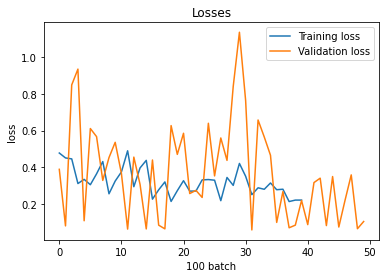

AUC=0.7929193836990067
Epoch: 01 | Epoch Time: 14m 59s
Epoch=2
Batch Id=0, Train Loss=0.27112334966659546
Batch Id=100, Train Loss=0.2325092852115631
Batch Id=200, Train Loss=0.2810927927494049
Batch Id=300, Train Loss=0.2081403136253357
Batch Id=400, Train Loss=0.2416774034500122
Batch Id=500, Train Loss=0.2765394449234009
Batch Id=600, Train Loss=0.32531118392944336
Batch Id=700, Train Loss=0.2479275017976761
Batch Id=0, Validation Loss=0.4525129199028015
Batch Id=100, Validation Loss=0.5760940313339233
Batch Id=200, Validation Loss=0.30924832820892334
Batch Id=300, Validation Loss=0.5208142399787903
Batch Id=400, Validation Loss=0.6918395757675171
Batch Id=500, Validation Loss=0.33127111196517944
Batch Id=600, Validation Loss=0.85387122631073
Batch Id=700, Validation Loss=0.0794166624546051
Batch Id=800, Validation Loss=0.053547222167253494
Batch Id=900, Validation Loss=0.046203792095184326


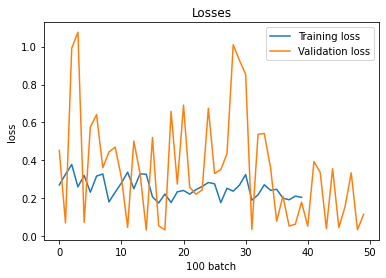

AUC=0.8082992878673247
Epoch: 02 | Epoch Time: 14m 58s


In [10]:
run()